<B>Цель</B> - Нужно проанализировать поведение клиентов и сделать вывод — какой тариф лучше

Входные данные:
Таблица <i>users</i> (информация о пользователях):
    - user_id — уникальный идентификатор пользователя
    - first_name — имя пользователя
    - last_name — фамилия пользователя
    - age — возраст пользователя (годы)
    - reg_date — дата подключения тарифа (день, месяц, год)
    - churn_date — дата прекращения пользования тарифом (если значение пропущено, то тариф ещё действовал на момент выгрузки данных)
    - city — город проживания пользователя
    - tariff — название тарифного плана
Таблица <i>calls</i> (информация о звонках):
    - id — уникальный номер звонка
    - call_date — дата звонка
    - duration — длительность звонка в минутах
    - user_id — идентификатор пользователя, сделавшего звонок
Таблица <i>messages</i> (информация о сообщениях):
    - id — уникальный номер сообщения
    - message_date — дата сообщения
    - user_id — идентификатор пользователя, отправившего сообщение
Таблица <i>internet</i> (информация об интернет-сессиях):
    - id — уникальный номер сессии
    - mb_used — объём потраченного за сессию интернет-трафика (в мегабайтах)
    - session_date — дата интернет-сессии
    - user_id — идентификатор пользователя
Таблица <i>tariffs</i> (информация о тарифах):
    - tariff_name — название тарифа
    - rub_monthly_fee — ежемесячная абонентская плата в рублях
    - minutes_included — количество минут разговора в месяц, включённых в абонентскую плату
    - messages_included — количество сообщений в месяц, включённых в абонентскую плату
    - mb_per_month_included — объём интернет-трафика, включённого в абонентскую плату (в мегабайтах)
    - rub_per_minute — стоимость минуты разговора сверх тарифного пакета (например, если в тарифе 100 минут разговора в месяц, то со 101 минуты будет взиматься плата)
    - rub_per_message — стоимость отправки сообщения сверх тарифного пакета
    - rub_per_gb — стоимость дополнительного гигабайта интернет-трафика сверх тарифного пакета (1 гигабайт = 1024 мегабайта)

<H2>Открытие данных</H2>

In [1]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

calls = pd.read_csv('/datasets/calls.csv')
internet = pd.read_csv('/datasets/internet.csv')
messages = pd.read_csv('/datasets/messages.csv')
tariffs = pd.read_csv('/datasets/tariffs.csv')
users = pd.read_csv('/datasets/users.csv')

Для поиска проблем в данных смотрю информацию по каждому датасету 

In [2]:
calls.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 202607 entries, 0 to 202606
Data columns (total 4 columns):
id           202607 non-null object
call_date    202607 non-null object
duration     202607 non-null float64
user_id      202607 non-null int64
dtypes: float64(1), int64(1), object(2)
memory usage: 6.2+ MB


In [3]:
calls.head()

,id,call_date,duration,user_id
0,1000_0,2018-07-25,0.00,1000
1,1000_1,2018-08-17,0.00,1000
2,1000_2,2018-06-11,2.85,1000
3,1000_3,2018-09-21,13.80,1000
4,1000_4,2018-12-15,5.18,1000


In [4]:
calls.duplicated().unique()

array([False])

In [5]:
internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
Unnamed: 0      149396 non-null int64
id              149396 non-null object
mb_used         149396 non-null float64
session_date    149396 non-null object
user_id         149396 non-null int64
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [6]:
internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [7]:
internet.duplicated().unique()

array([False])

In [8]:
messages.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 123036 entries, 0 to 123035
Data columns (total 3 columns):
id              123036 non-null object
message_date    123036 non-null object
user_id         123036 non-null int64
dtypes: int64(1), object(2)
memory usage: 2.8+ MB


In [9]:
messages.head()

,id,message_date,user_id
0,1000_0,2018-06-27,1000
1,1000_1,2018-10-08,1000
2,1000_2,2018-08-04,1000
3,1000_3,2018-06-16,1000
4,1000_4,2018-12-05,1000


In [10]:
messages.duplicated().unique()

array([False])

In [11]:
tariffs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 8 columns):
messages_included        2 non-null int64
mb_per_month_included    2 non-null int64
minutes_included         2 non-null int64
rub_monthly_fee          2 non-null int64
rub_per_gb               2 non-null int64
rub_per_message          2 non-null int64
rub_per_minute           2 non-null int64
tariff_name              2 non-null object
dtypes: int64(7), object(1)
memory usage: 256.0+ bytes


In [12]:
tariffs.head()

,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute,tariff_name
0,50,15360,500,550,200,3,3,smart
1,1000,30720,3000,1950,150,1,1,ultra


In [13]:
tariffs.duplicated().unique()

array([False])

In [14]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500 entries, 0 to 499
Data columns (total 8 columns):
user_id       500 non-null int64
age           500 non-null int64
churn_date    38 non-null object
city          500 non-null object
first_name    500 non-null object
last_name     500 non-null object
reg_date      500 non-null object
tariff        500 non-null object
dtypes: int64(2), object(6)
memory usage: 31.4+ KB


In [15]:
users.head()

,user_id,age,churn_date,city,first_name,last_name,reg_date,tariff
0,1000,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra
1,1001,41,NaN,Москва,Иван,Ежов,2018-11-01,smart
2,1002,59,NaN,Стерлитамак,Евгений,Абрамович,2018-06-17,smart
3,1003,23,NaN,Москва,Белла,Белякова,2018-08-17,ultra
4,1004,68,NaN,Новокузнецк,Татьяна,Авдеенко,2018-05-14,ultra


In [16]:
users.duplicated().unique()

array([False])

<H4>Выводы</H4>

В предоставленных данных особых проблем нет, пропуски присутствуют в единственном датафрейме (users), но и они регламентированы. Дубликаты в данных отсутствуют. В следующем пункте необходимо сделать следующее:
    - удалить столбец Unnamed: 0 из датафрейма internet    
Так же было решено избавиться от звонков длительностью 0 минут и трафика объемом 0 МБ так как эти данные могут повлиять на итоговый результат

<H2>Подготовка данных</H2>

Задачи:
- [x] Приведите данные к нужным типам;
- [x] Найдите и исправьте ошибки в данных.

Посчитать для каждого пользователя:
- [x] количество сделанных звонков и израсходованных минут разговора по месяцам;
- [x] количество отправленных сообщений по месяцам;
- [x] объем израсходованного интернет-трафика по месяцам;
- [x] помесячную выручку с каждого пользователя (вычтите бесплатный лимит из суммарного количества звонков, сообщений и интернет-трафика;остаток умножьте на значение из тарифного плана; прибавьте абонентскую плату, соответствующую тарифному плану).

Произвожу округление длительности звонков согласно заданию

In [17]:
calls['duration'] = calls['duration'].apply(np.ceil)

Удаляю ненужный столбец 

In [18]:
internet.drop(['Unnamed: 0'], axis='columns', inplace=True)

фильтрую данные, оставляя только оплаченые звонки и трафик

In [19]:
calls = calls.query('duration>0')
internet = internet.query('mb_used>0')

обновляю индексы в отфильтрованных данных

In [20]:
calls.reset_index(drop=True)
internet.reset_index(drop=True)

,id,mb_used,session_date,user_id
0,1000_0,112.95,2018-11-25,1000
1,1000_1,1052.81,2018-09-07,1000
2,1000_2,1197.26,2018-06-25,1000
3,1000_3,550.27,2018-08-22,1000
4,1000_4,302.56,2018-09-24,1000
...,...,...,...,...
129793,1499_151,752.72,2018-10-11,1499
129794,1499_152,318.90,2018-10-03,1499
129795,1499_153,490.13,2018-12-14,1499
129796,1499_155,1246.32,2018-11-26,1499


Привожу все фичи, которые являются датами к формату datetime для последующей работы с ними(ну и так вообще правильней)

In [21]:
calls['call_date'] = pd.to_datetime(calls['call_date'], format='%Y-%m-%d %H:%M:%S')
internet['session_date'] = pd.to_datetime(internet['session_date'], format='%Y-%m-%d %H:%M:%S')
messages['message_date'] = pd.to_datetime(messages['message_date'], format='%Y-%m-%d %H:%M:%S')
users['reg_date'] = pd.to_datetime(users['reg_date'], format='%Y-%m-%d %H:%M:%S')

Добавляю столбец со значением месяца к каждому рассчитываемому параметру

In [22]:
calls['months'] = calls['call_date'].map(lambda x: x.month)
internet['months'] = internet['session_date'].map(lambda x: x.month)
messages['months'] = messages['message_date'].map(lambda x: x.month)

Собираю три таблички по трем видам услуг в разрезе каждого пользователя и месяца, и объемом услуг. 
<br>После чего переименовываю столбцы

In [23]:
count_calls_by_months = calls.pivot_table(index=['user_id', 'months'], values='duration', aggfunc=('count', 'sum'))
count_traffic_by_months = internet.pivot_table(index=['user_id', 'months'], values='mb_used', aggfunc='sum')
count_messages_by_months = messages.pivot_table(index=['user_id', 'months'], values='id', aggfunc='count')

count_calls_by_months.columns = ['calls_count', 'calls_sum']
count_traffic_by_months.columns = ['mb_sum']
count_messages_by_months.columns = ['messages_count']

Объединяю таблицы в одну для более удобной работы

In [24]:
users_by_month = count_calls_by_months.join([count_traffic_by_months, count_messages_by_months])

Переименовываю столбцы в соответствии с уровнем, перераспределяю индексацию и заполняю пропуски 0. 
<br>Пропуски у нас есть только по значению когда пользователь разорвал контракт о предоставлении услуг сотовой свзяи
<br>Заполнение 0 никак не повлияет на конечный результат

In [25]:
users_by_month['id'] = users_by_month.index.get_level_values('user_id')
users_by_month['months'] = users_by_month.index.get_level_values('months')
users_by_month = users_by_month.reset_index(drop = True)
users_by_month = users_by_month.fillna(0)

Переименовываю столбцы

In [26]:
users.set_axis(['id', 
                'age', 
                'churn_date', 
                'city', 
                'first_name', 
                'last_name', 
                'reg_date', 
                'tariff_name'], 
               axis = 'columns', 
               inplace = True)

Добавляю в собираемую таблицу информацию о пользователе и тарифе

In [27]:
users_by_month = users_by_month.merge(users, on='id')
users_by_month = users_by_month.merge(tariffs, on='tariff_name')

In [28]:
users_by_month.head()

,calls_count,calls_sum,mb_sum,messages_count,id,months,age,churn_date,city,first_name,last_name,reg_date,tariff_name,messages_included,mb_per_month_included,minutes_included,rub_monthly_fee,rub_per_gb,rub_per_message,rub_per_minute
0,17.0,159.0,2253.49,22.0,1000,5,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
1,28.0,172.0,23233.77,60.0,1000,6,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
2,41.0,340.0,14003.64,75.0,1000,7,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
3,42.0,408.0,14055.93,81.0,1000,8,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1
4,46.0,466.0,14568.91,57.0,1000,9,52,NaN,Краснодар,Рафаил,Верещагин,2018-05-25,ultra,1000,30720,3000,1950,150,1,1


Создаю функцию для рассчета стоимости оплаты услуг каждым пользователем 

In [29]:
def payed(data):
    minuts_over = 0
    gb_over = 0
    message_over = 0
    
    tar_min = data['minutes_included']
    if data['calls_sum'] > tar_min:
        minuts_over = math.ceil(data['calls_sum'] - tar_min)
    
    tar_mess = data['messages_included']
    if data['messages_count'] > tar_mess:
        message_over = math.ceil(data['messages_count'] - tar_mess)
        
    tar_mb = data['mb_per_month_included']
    if data['mb_sum'] > tar_mb:
        gb_over = math.ceil((data['mb_sum'] - tar_mb) / 1024)
        
    summa = (data['rub_monthly_fee'] + 
             minuts_over * data['rub_per_minute'] + 
             message_over * data['rub_per_message'] + 
             gb_over * data['rub_per_gb'])
    
    return summa


#Создаю столбец с количеством денег, которые оплатил каждый пользователе помесячно
users_by_month['payed'] = users_by_month.apply(payed, axis=1)

In [30]:
users_by_month.count()

calls_count              3168
calls_sum                3168
mb_sum                   3168
messages_count           3168
id                       3168
months                   3168
age                      3168
churn_date                187
city                     3168
first_name               3168
last_name                3168
reg_date                 3168
tariff_name              3168
messages_included        3168
mb_per_month_included    3168
minutes_included         3168
rub_monthly_fee          3168
rub_per_gb               3168
rub_per_message          3168
rub_per_minute           3168
payed                    3168
dtype: int64

In [31]:
#Ниже провожу расчетыы для интересных фактов из таблицы. тут расчитываю количество пользователей с тарифом smart
users_by_month.query('tariff_name == "smart"')['id'].count()

2221

In [32]:
#тут расчитываю количество пользователей с тарифом ultra
users_by_month.query('tariff_name == "ultra"')['id'].count()

947

In [33]:
#тут расчитываю количество пользователей с тарифом smart которые переплатили
users_by_month.query('tariff_name == "smart" and payed > 550')['id'].count()

1657

In [34]:
#тут расчитываю количество пользователей с тарифом smart которые переплатили больше чем если бы у них был тариф ultra
users_by_month.query('tariff_name == "smart" and payed > 1950')['id'].count()

417

In [35]:
#тут расчитываю количество пользователей с тарифом ultra которые переплатили
users_by_month.query('tariff_name == "ultra" and payed > 1950')['id'].count()

128

In [36]:
#тут расчитываю максимальный платеж пользователя с тарифом smart
users_by_month.query('tariff_name == "smart"')['payed'].max()

6770

In [37]:
#тут расчитываю максимальный платеж пользователя с тарифом ultra
users_by_month.query('tariff_name == "ultra"')['payed'].max()

4800

<H4>Выводы</H4>

 В рамках данного блока была получена сводная таблица, в которой разбиты пользователи по месяцам. Вот некоторые сведения из данной таблицы:
- Почти в 75% случаев пользователи тарифа smart переплачивают за свой тариф
- Около 19% случаев когда за тариф smart заплатили больше, чем за тариф ultra
- В 14% случаев пользователи переплачивают за тариф ultra
- Максимальная сумма, оплаченая за тариф smart - 6770
- Максимальная сумма, оплаченая за тариф ultra - 4800

<H2>Анализ данных</H2>

In [38]:
users_by_month_smart = users_by_month.query('tariff_name == "smart"')
users_by_month_ultra = users_by_month.query('tariff_name == "ultra"')

In [39]:
def visual_result(df):
    params = ['mb_sum', 'messages_count', 'calls_sum', 'calls_count'];
    boxplot_values = ['megabyte rate', 'message count', 'call duration', 'call count']
    i = 0
    plt.style.use('seaborn-muted')
    for param in params:
        print('\nParam = ', param)
        plt.figure()
        plt.xlabel('Count')
        plt.ylabel('Frequency')
        plt.title(param)
        plt.hist(x=df[param], bins=100)
        plt.show()
        plt.figure()
        sns.boxplot(x=df[param])
        plt.xlabel(boxplot_values[i])
        plt.show()
        i+=1
        print('Mean', param, 'in month:', df[param].mean())
        print('Median', param, 'in month:', df[param].median())
        print('Dispersion', param, 'in month:', np.var(df[param]))
        print('Standart deviation', param, 'in months:', np.sqrt(np.var(df[param])))
        if df[param].median() < df[param].mean():
            print('Positive bias')
        elif df[param].median() > df[param].mean():
            print('Negative bias')
        else:
            print('Median=mean')
        print('\n____________________________________________________________________________')
        


Param =  mb_sum


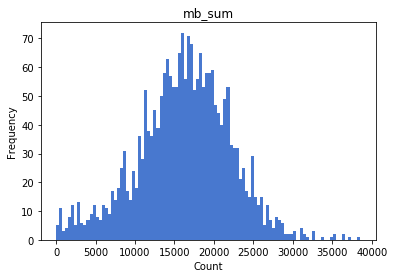

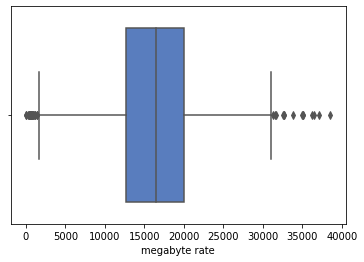

Mean mb_sum in month: 16210.658185502025
Median mb_sum in month: 16504.11
Dispersion mb_sum in month: 34515840.53476398
Standart deviation mb_sum in months: 5875.018343355532
Negative bias

____________________________________________________________________________

Param =  messages_count


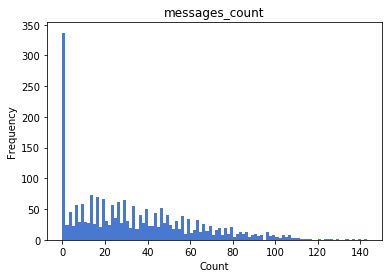

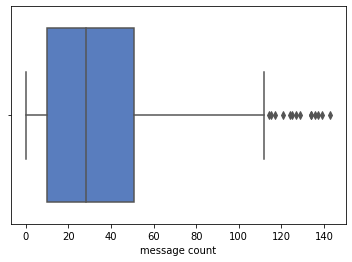

Mean messages_count in month: 33.392165691130124
Median messages_count in month: 28.0
Dispersion messages_count in month: 798.8462060707005
Standart deviation messages_count in months: 28.26386750023253
Positive bias

____________________________________________________________________________

Param =  calls_sum


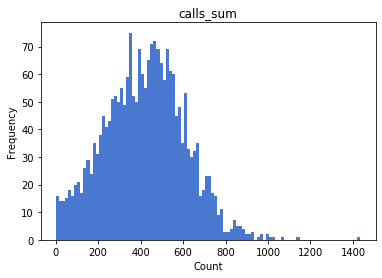

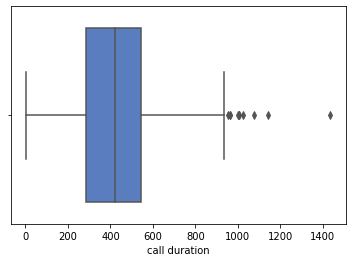

Mean calls_sum in month: 419.4403421882035
Median calls_sum in month: 423.0
Dispersion calls_sum in month: 35702.04653099502
Standart deviation calls_sum in months: 188.9498518946099
Negative bias

____________________________________________________________________________

Param =  calls_count


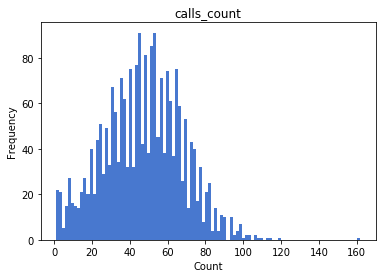

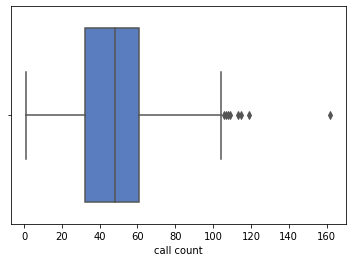

Mean calls_count in month: 47.11661413777578
Median calls_count in month: 48.0
Dispersion calls_count in month: 436.07419943192974
Standart deviation calls_count in months: 20.882389696390828
Negative bias

____________________________________________________________________________


In [40]:
visual_result(users_by_month_smart)


Param =  mb_sum


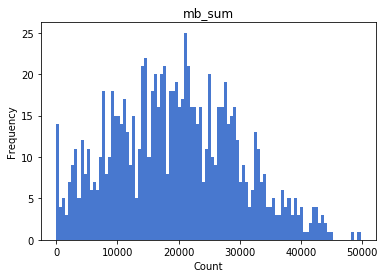

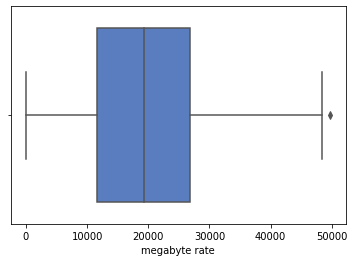

Mean mb_sum in month: 19471.580633579724
Median mb_sum in month: 19315.85
Dispersion mb_sum in month: 102465744.0285935
Standart deviation mb_sum in months: 10122.536442443341
Positive bias

____________________________________________________________________________

Param =  messages_count


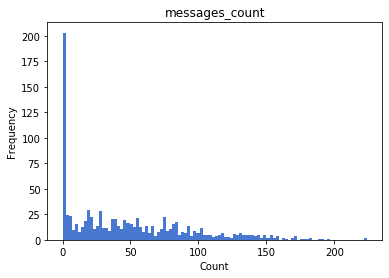

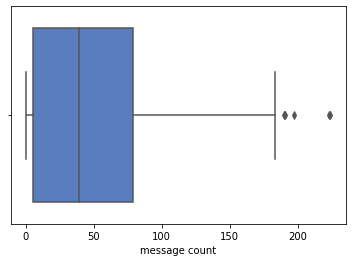

Mean messages_count in month: 48.75923970432946
Median messages_count in month: 39.0
Dispersion messages_count in month: 2169.4330587672516
Standart deviation messages_count in months: 46.577173151311484
Positive bias

____________________________________________________________________________

Param =  calls_sum


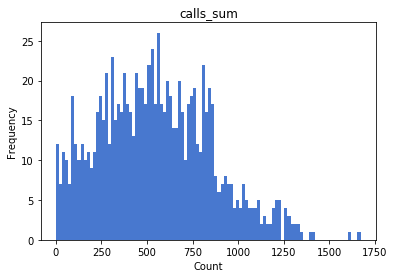

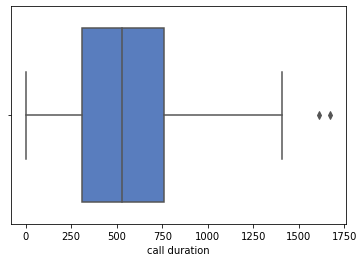

Mean calls_sum in month: 547.7550158394931
Median calls_sum in month: 529.0
Dispersion calls_sum in month: 93239.86606512647
Standart deviation calls_sum in months: 305.35203628783364
Positive bias

____________________________________________________________________________

Param =  calls_count


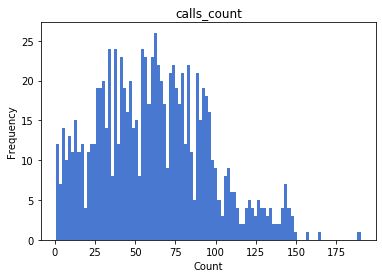

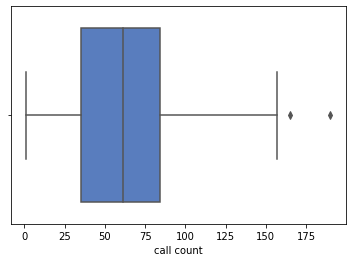

Mean calls_count in month: 61.613516367476244
Median calls_count in month: 61.0
Dispersion calls_count in month: 1167.6668922814108
Standart deviation calls_count in months: 34.17114122006186
Positive bias

____________________________________________________________________________


In [41]:
visual_result(users_by_month_ultra)

<H4>Выводы</H4>

Основываясь на скошенности гистограм можно сделать следующие выводы:
    - Пользователи тарифа smart выходят за рамки пакета по следующим видам услуг: пакет интернета, пакет минут и соответственно докупают необходимые пакеты
    - Пользователям тарифа ultra зачастую хватает предоставляемого им пакета услуг
    - Смс не является востребованным методом общения ни на одном из тарифов

<H2>Проверка гипотез</H2>

H0: Cредняя выручка пользователей тарифов «Ультра» и «Смарт» не различается
<br>H1 (альтернативная): Cредняя выручка пользователей тарифов «Ультра» и «Смарт» различается

In [42]:
from scipy import stats as st

alpha = 0.05

results = st.ttest_ind(
     users_by_month_smart['payed'],
    users_by_month_ultra['payed']
   
    )

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 8.145017201938894e-155
Отвергаем нулевую гипотезу


H0: средняя выручка пользователей из Москвы не отличается от выручки пользователей из других регионов;
<br>H1 (альтернативная): средняя выручка пользователей из Москвы отличается от выручки пользователей из других регионов;

In [43]:
users_from_moscow = users_by_month.query('city == "Москва"')
users_not_from_moscow = users_by_month.query('city != "Москва"')


In [44]:
from scipy import stats as st

alpha = 0.05

results = st.ttest_ind(
    users_from_moscow['payed'], 
    users_not_from_moscow['payed'],
    )

print('p-значение:', results.pvalue)

if (results.pvalue < alpha):
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.45718519583645034
Не получилось отвергнуть нулевую гипотезу


<H4>Выводы</H4>

Cредняя выручка пользователей тарифов «ultra» и «smart» различается. Это было доказано при помощи теоремы стьюдента для двух независимых выборок. Этим же методом было доказано что разница в расходах москвичей и не-москвичей не различается.

<H2>Общие выводы</H2>

Пользователи тарифа smart очень часто тратят пакет быстрее чем за месяц, что вынуждает их докупать дополнительные пакеты, принося тем самым прибыль компании. Чего нельзя сказать о пользователях тарифа ultra. К докупке пакетов интернета и звонков данные пользователи прибегают крайне редко. Бывают случаи, когда некоторые пользователи платят за тариф smart больше, чем за тариф ultra. СМС никому не нужны (что поделать, в такое время живем). С моей точки зрения для оператора <b>выгодней продвигать тариф ultra</b>, так как он приносит доход за оверпрайснутые пакеты. К тому же данный тариф по карману большей группе населения, ведь не каждый готов платить почти 2000 рублей за тариф.
Ниже приведены некоторые интересные факты из работы:
- Почти в 75% случаев пользователи тарифа smart переплачивают за свой тариф
- Около 19% случаев когда за тариф smart заплатили больше, чем за тариф ultra
- В 14% случаев пользователи переплачивают за тариф ultra
- Максимальная сумма, оплаченная за тариф smart - 6770
- Максимальная сумма, оплаченная за тариф ultra - 4800
- Средняя выручка для компании от пользователей тарифа smart и пользователей тарифа ultra различается
- Разница в расходах москвичей и не-москвичей не различается